# Train chosen model

libraries

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from os import path, listdir
from cv2 import imread, resize
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import efficientnet
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from random import randint
from typing import Iterable
from seaborn import heatmap

load data

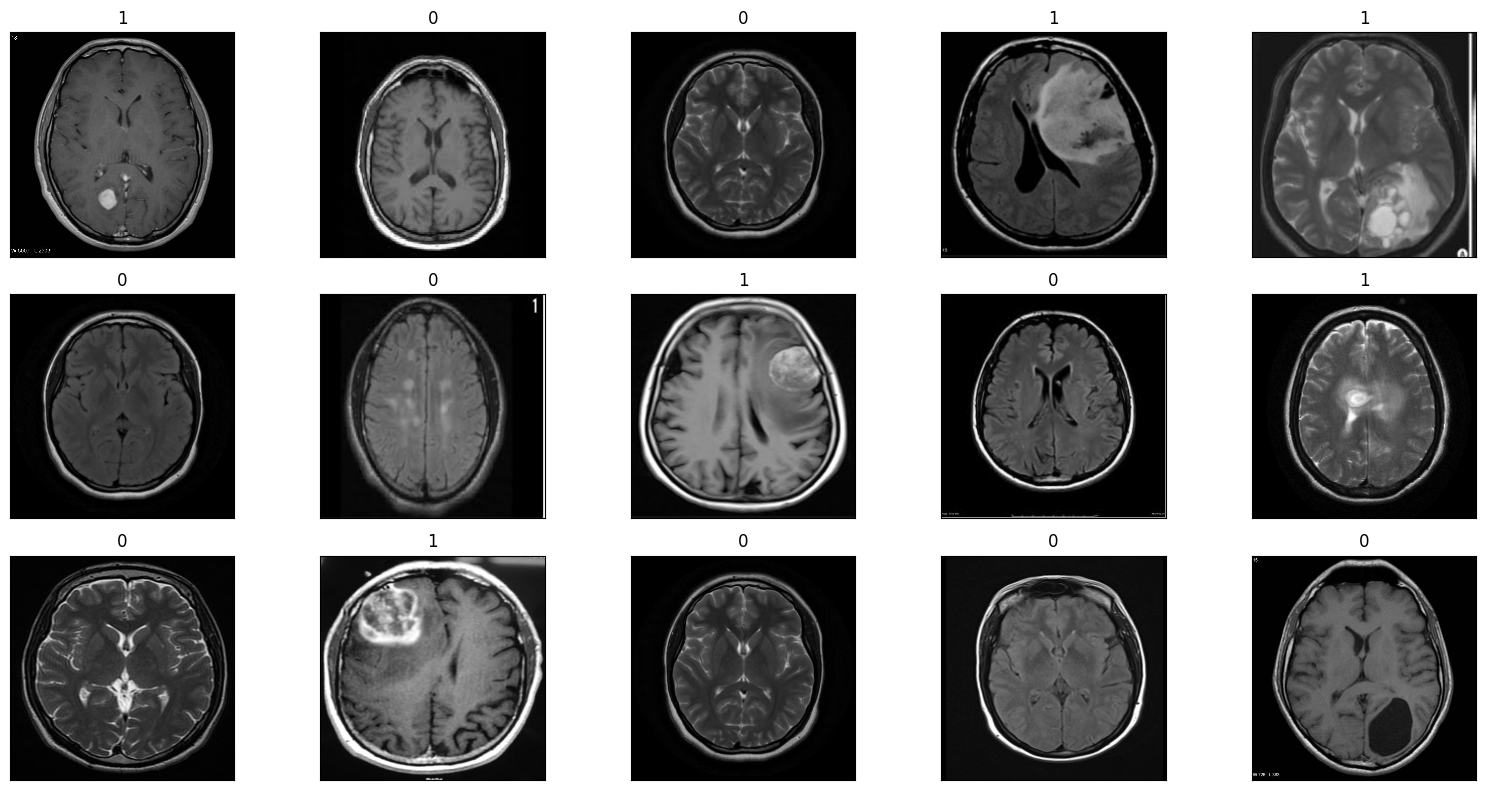

In [72]:
no_path = '../archive/brain_tumor_dataset/no'
yes_path = '../archive/brain_tumor_dataset/yes'
images = []
labels = [] # label 0 is no tumor, label 1 tumor occurs
for path_ in (no_path, yes_path):
    if path_ == no_path:
        default_label = 0
    elif path_ == yes_path:
        default_label = 1
    else:
        raise(Exception("What's going on?? No such file or directory"))
    
    for filename in listdir(path_):
        img_path = path.join(path_, filename)
        
        img = imread(img_path)
        
        # resize to convenient shape for CNN's
        img = resize(img, (224,224))
        
        images.append(img)
        labels.append(default_label)

images = np.array(images)
labels = np.array(labels)

plt.figure(figsize=(16,8))
max_idx = len(labels)-1
for num in range(15):
    i = randint(0,max_idx)
    plt.subplot(3, 5, num + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(int(labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

split data

In [73]:
random_state = 509
def split_data(*images_list: Iterable, train_size: float=0.8, random_state: int=random_state):
    """Prepare data for CNN's. Split data by sklearn.model_selection.train_test_split, convert to np.array type, and categorize labels.

    Args:
        images_list (Iterable): Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
        train_size (float, Optional): Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. Defaults to 0.8.
        random_state (int, Optional): Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. Defaults to 112.
        
    """
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=train_size, random_state=random_state) # images is raw data without being preprocessed, 
    # optionally load here preprocessed data by cnn's own algorithm instead, for example efficientnet_images (every cnn has its own prep. algorithm)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(images)

# make labels categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

prepare model

In [74]:
# preprocess images to fit for efficientnet
efficientnet_images = efficientnet.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(efficientnet_images)


efficientnet_base_model = efficientnet.EfficientNetB4(
    include_top=False, # set to false to not including classification layers
    # imagenet was trained with range 1000 of classes, we need just 2 - will be added in the next step
    weights='imagenet', # weights to be loaded, pretrained model imagenet, fits to MRI images well
    input_shape=(224, 224, 3),
)

# XXX classification layer + freezing weights from imagenet
for layer in efficientnet_base_model.layers: # freeze the layers because models is already pretraind and it isn't neede to train it from scratch
    layer.trainable = False 
### configure output layers :
x = layers.Flatten()(efficientnet_base_model.output)
# prevent overfitting by adding drouppout layer
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
efficientnet_model = models.Model(inputs=efficientnet_base_model.input, outputs=x)
efficientnet_model.summary(layer_range=(efficientnet_model.layers[0].name, efficientnet_model.layers[13].name), show_trainable=True)
print("\t. . .\t")
efficientnet_model.summary(layer_range=(efficientnet_model.layers[-14].name, efficientnet_model.layers[-1].name), show_trainable=True)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_16      │ (None, 224,     │         0 │ input_layer_8… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization_8   │ (None, 224,     │         7 │ rescaling_16[… │   N   │
│ (Normalization)   │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_17      │ (None, 224,     │         0 │ normalization… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv_pad     │ (None, 225,     │         0 │ rescaling_17[… │   -   │
│ (ZeroPadding2D)   │ 225, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │     1,296 │ stem_conv_pad… │   N   │
│ (Conv2D)          │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │       192 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_dwconv    │ (None, 112,     │       432 │ stem_activati… │   N   │
│ (DepthwiseConv2D) │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_bn        │ (None, 112,     │       192 │ block1a_dwcon… │   N   │
│ (BatchNormalizat… │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_activati… │ (None, 112,     │         0 │ block1a_bn[0]… │   -   │
│ (Activation)      │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_squee… │ (None, 48)      │         0 │ block1a_activ… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_resha… │ (None, 1, 1,    │         0 │ block1a_se_sq… │   -   │
│ (Reshape)         │ 48)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_reduce │ (None, 1, 1,    │       588 │ block1a_se_re… │   N   │
│ (Conv2D)          │ 12)             │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 17,849,441 (68.09 MB)

 Trainable params: 175,618 (686.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

	. . .	


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ block7b_se_resha… │ (None, 1, 1,    │         0 │ block7b_se_sq… │   -   │
│ (Reshape)         │ 2688)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_reduce │ (None, 1, 1,    │   301,168 │ block7b_se_re… │   N   │
│ (Conv2D)          │ 112)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_expand │ (None, 1, 1,    │   303,744 │ block7b_se_re… │   N   │
│ (Conv2D)          │ 2688)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_excite │ (None, 7, 7,    │         0 │ block7b_activ… │   -   │
│ (Multiply)        │ 2688)           │           │ block7b_se_ex… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_project_… │ (None, 7, 7,    │ 1,204,224 │ block7b_se_ex… │   N   │
│ (Conv2D)          │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_project_… │ (None, 7, 7,    │     1,792 │ block7b_proje… │   N   │
│ (BatchNormalizat… │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_drop      │ (None, 7, 7,    │         0 │ block7b_proje… │   -   │
│ (Dropout)         │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_add (Add) │ (None, 7, 7,    │         0 │ block7b_drop[… │   -   │
│                   │ 448)            │           │ block7a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_conv (Conv2D) │ (None, 7, 7,    │   802,816 │ block7b_add[0… │   N   │
│                   │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_bn            │ (None, 7, 7,    │     7,168 │ top_conv[0][0] │   N   │
│ (BatchNormalizat… │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_activation    │ (None, 7, 7,    │         0 │ top_bn[0][0]   │   -   │
│ (Activation)      │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ flatten_8         │ (None, 87808)   │         0 │ top_activatio… │   -   │
│ (Flatten)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_8         │ (None, 87808)   │         0 │ flatten_8[0][… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_8 (Dense)   │ (None, 2)       │   175,618 │ dropout_8[0][… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 17,849,441 (68.09 MB)

 Trainable params: 175,618 (686.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

train model

In [75]:
# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True, # hold best epoch weights
    start_from_epoch=5
)

# fit data with validation
efficientnet_history = efficientnet_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
efficientnet_predictions = efficientnet_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4925 - loss: 7.7286 - recall: 0.4925 - val_accuracy: 0.7843 - val_loss: 0.9235 - val_recall: 0.7843
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7799 - loss: 2.5725 - recall: 0.7799 - val_accuracy: 0.8235 - val_loss: 1.5820 - val_recall: 0.8235
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8312 - loss: 2.2191 - recall: 0.8312 - val_accuracy: 0.8824 - val_loss: 0.9501 - val_recall: 0.8824
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8691 - loss: 1.2035 - recall: 0.8691 - val_accuracy: 0.8824 - val_loss: 0.8805 - val_recall: 0.8824
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8833 - loss: 1.2028 - recall: 0.8833 - val_accuracy: 0.9020 - val_loss: 0.8371 - val_recall: 0.9020
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9366 - loss: 0.3597 - recall: 0.9366 - val_accuracy: 0.9608 - val_loss: 0.3843 - val_recall: 0.9608
Epoch 7/30
7/7 ━━━━━━━━━━━━━

report

In [76]:
best_epoch = min(range(len(efficientnet_history.history['val_loss'])), key=lambda i: efficientnet_history.history['val_loss'][i])
print(f'Best epoch is: {best_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
efficientnet_predictions_classes = np.argmax(efficientnet_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, efficientnet_predictions_classes))

Best epoch is: 6

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.94      1.00      0.97        30

    accuracy                           0.96        51
   macro avg       0.97      0.95      0.96        51
weighted avg       0.96      0.96      0.96        51



show output

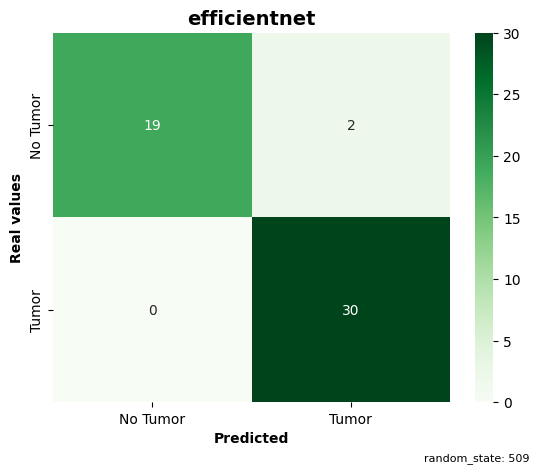

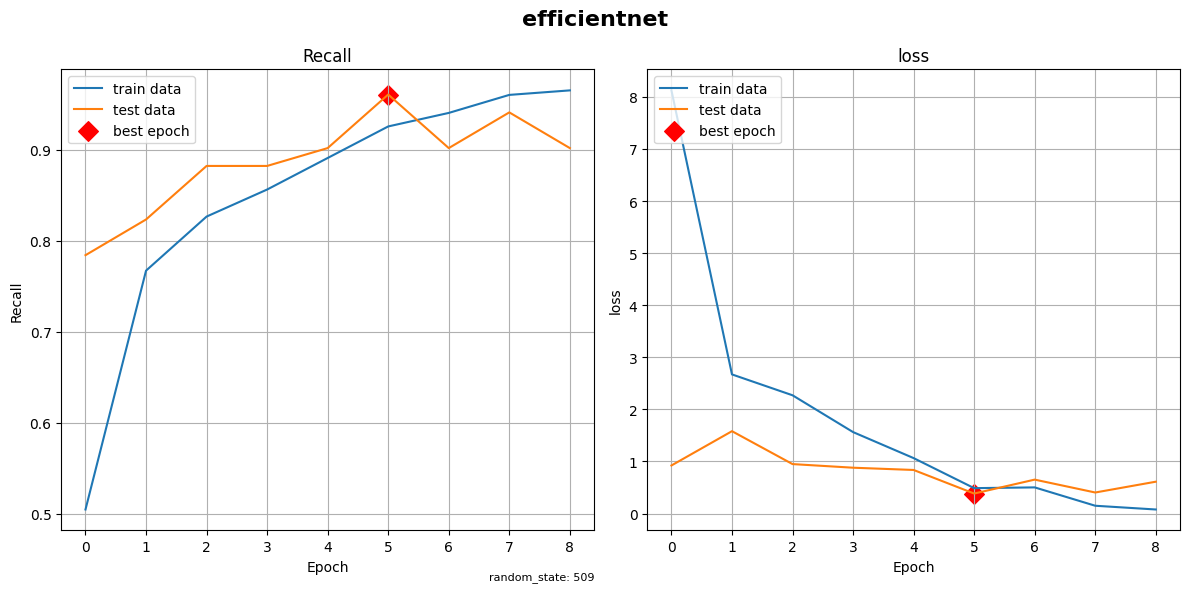

In [77]:
cf_matrix = confusion_matrix(y_test_labels, efficientnet_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('efficientnet', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/efficientnet_last_fig_cf.png", dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(12, 6))

# Name
plt.suptitle('efficientnet', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['recall'], label='train data')
plt.plot(efficientnet_history.history['val_recall'], label='test data')
plt.scatter(best_epoch, efficientnet_history.history['val_recall'][best_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='train data')
plt.plot(efficientnet_history.history['val_loss'], label='test data')
plt.scatter(best_epoch, efficientnet_history.history['val_loss'][best_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/efficientnet_last_fig.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

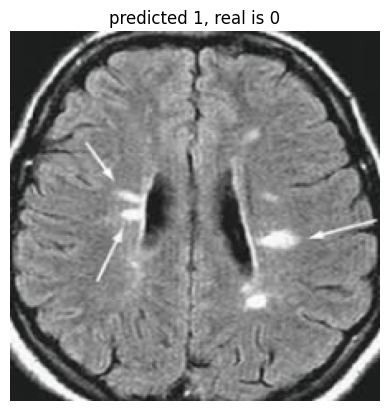

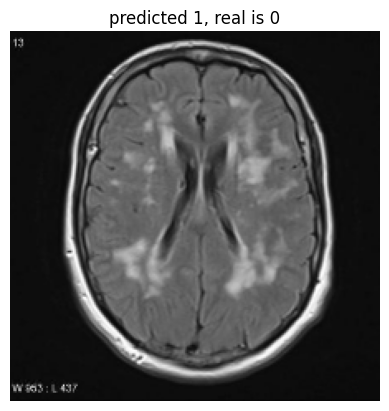

In [78]:
predicted_labels = np.argmax(efficientnet_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

for idx in incorrect_indices:
    plt.imshow(X_test[idx])
    plt.title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    plt.axis('off')
    plt.show()

save

In [83]:
efficientnet_model.save('../models/EfficientNet.keras', include_optimizer=False)